# Recommending Movies

Recommendation systems/engines/algorithms are a means to filter information to make recommendations to users. They are used for predicting a user's behavior based on their past behavior or behavior of related users.

In the current project, I seek to predict movie preferences of users. 
__So let's get started.__

I will be using the moviedataset that [Cognitive Class AI](https://cognitiveclass.ai). The original source of the dataset can be found [here](http://grouplens.org/datasets/movielens/). There are significantly larger datasets with 20 Million Movie ratings as well as 20 Million Youtube Trailers datasets. If you want to work on an even larger (but synthetic dataset extrapolated from the 20M real-world ratings) you can use [this](http://files.grouplens.org/datasets/movielens/ml-20mx16x32.tar) dataset.  

In [1]:
# let's get the basic imports out of the way. I will be using pandas for storing and manipulating the data.

import pandas as pd
from math import sqrt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

# Let's make sure matplotlib shows all the figures inline
%matplotlib inline

##### Time to import the data.
If you need to download the data, go [here.](https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/moviedataset.zip)

The dataset consists of 4 csv files -- links.csv, movies.csv, ratings.csv, tags.csv -- each consisting of relevant information. I will store the data from each of those files in separate dataframes, and write them into a new dataframe as needed.

In [2]:
# Here is the movie informatoin dataset
movies_df = pd.read_csv('../Downloads/moviedataset/ml-latest/movies.csv')

# Let's take a look at the first 5 lines of this dataset
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


There are a few things we need to take care of in this dataset. For instance, the year within the paranthesis need to be extracted and saved to a new column. Furthermore, we also need to split the genres into multiple columns so they are easier to work with.

But before we start working on that, we should look at the rest of the files, in case we can write a function to clean the data instead of cleaning them one at a time.

In [3]:
# Here is the movie information dataset
ratings_df = pd.read_csv('../Downloads/moviedataset/ml-latest/ratings.csv')

# Let's take a look at the first 5 lines of this dataset
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


In [4]:
# Here is the movie informatoin dataset
links_df = pd.read_csv('../Downloads/moviedataset/ml-latest/links.csv')

# Let's take a look at the first 5 lines of this dataset
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
# Here is the movie informatoin dataset
tags_df = pd.read_csv('../Downloads/moviedataset/ml-latest/tags.csv')

# Let's take a look at the first 5 lines of this dataset
tags_df.head()

,userId,movieId,tag,timestamp
0,19,2324,bittersweet,1428651158
1,19,2324,holocaust,1428651112
2,19,2324,World War II,1428651118
3,23,7075,hilarious,1378675786
4,23,7075,Underrated,1378675786


### Preprocessing the data

It appears the movieId is the common variable across all the datasets. Thus, we could use that column to combine these dataframes as we need them. The first thing to do is to clean the movies_df dataframe to extract the years and the genres.

In [6]:
# We can make use of regular expressions to find the year and the genres. First let's work on the years.

movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False) # to extract the string '(dddd)' from title column'

movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False) # since we no longer need the paranthesis, we remove them.

movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '') # Now that we have the years extracted, let's drop them and replace them with an empty string

movies_df['title'] = movies_df['title'].apply(lambda x: x.strip()) #to remove the trailing space

movies_df.head()

# Now that that is taken care of, let's split the genres.
# note the "|" that is used as a separator. We use this info to split the genres into multiple columns.

movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


##### Okay, we were able to successfully extract the year, removed the paranthesis, and turned it into a new column, "year".

While we were able to extract the genres and add them into a list without the old separator '|', we may not be able to use this information just yet, so let's move each genre into a separate column.

There are two ways to do this. We can simply split the genres into multiple columns and within each row, for each movie, we will have genre_1, genre_2,....genre_n.

However, the issue with this approach is that it would have an uneven number of genres for each movie, leading to a lot of empty values in columns beyond, genre_1 and genre_2 given that most movies within our data 
have at least 2 genres associated with the movie.

We get around this issue by using the One Hot Encoding approach, essentially, to create a dummy variable (1 if yes and 0 if no) for every genre for each movie. That way, we can see which genre a movie is part of which it is not a part of.

__Let's do this now!__

In [7]:
# We can copy the movie dataframe into a new one if you want to leave the movies_df dataset untouched.
# moviesWithGenres_df = movies_df.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies_df.iterrows():
    for genre in row['genres']:
        movies_df.at[index, genre] = 1
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
movies_df = movies_df.fillna(0)
movies_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Great! Now we have all the genres as their own respective columns with 1 if yes and 0 if no for the respective genre. Additionally, we have the genres as its own column, in case we need to quickly reference the genre for each of our movies. 

However, if we do not need this genres column, we can use the following line of code to drop it.

movies_df = movies_df.drop('genres', 1)

Now that we are done preprocessing the movies_df dataframe, let's shift our focus to the rest of the data. Let's start with ratings_df


In [8]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


We know for a fact that the timestamp does not provide any relevant information to us except the time at which the rating was posted. The time itself does not have any predictive value so we can safely drop this variable.

In [9]:
# Let's drop the timestamp.
ratings_df = ratings_df.drop('timestamp', 1)
ratings_df.head()

,userId,movieId,rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0


Let's do the same for the links_df.

In [10]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


We may not need the imdbId and tmdbId of each movie for our actual predictions, however, we might need it to cross-verify our data in case any of our data has erroneous movie ids. Thus, for the time-being let's leave them alone.


How about the tags_df?

In [11]:
tags_df.head()

,userId,movieId,tag,timestamp
0,19,2324,bittersweet,1428651158
1,19,2324,holocaust,1428651112
2,19,2324,World War II,1428651118
3,23,7075,hilarious,1378675786
4,23,7075,Underrated,1378675786


Again, we have no value for the timestamp, so we can safely remove them. The tag associated with each movie might be a key feature to predicting what kind of movie each user might like, so let's make sure to use it later in our modeling.

In [12]:
# removing the timestamp from tags_df

tags_df = tags_df.drop('timestamp', 1)
tags_df.head()

,userId,movieId,tag
0,19,2324,bittersweet
1,19,2324,holocaust
2,19,2324,World War II
3,23,7075,hilarious
4,23,7075,Underrated


That should be all for the cleaning. Fortunately, the data comes fairly clean otherwise and doesn't seem to have any issues that we need to worry about. So let's shift our focus to inspecting the data and then building our recommendation systems.

There are three common ways to build recommendation engines each with their own goals - 
1. __Popular__ - Recommending the most popular or trending
2. __Content-based__ - Recommending based on an individual's own watch history (or equivalent to watch history such as purchasing habits)
3. __Collaborative-filtering__ - Recommending based on watch history of related individuals (similar age groups, similar locality, similar background other demographics etc.)

There are a few other ways to build recommeder systems. For instance, multi-criteria recommender systems, risk-aware recommender systems, and hybrid recommender systems. To learn more about these, please check [wikipedia](https://en.wikipedia.org/wiki/Recommender_system).

Unfortunately, in our dataset, we do not have the information related to what is popular/trending. Thus, we cannot build a recommendation engine that can recommend based on popularity! Bummer! :(

However, we can test the other two! So, let's start with Content-based and then move on to Collaborative filtering.

p.s. You can follow the wonderful tutorial [here](https://medium.com/code-heroku/building-a-movie-recommendation-engine-in-python-using-scikit-learn-c7489d7cb145) if you would like to try the popularity based collaborative filtering and theoretical background primer if you would so like!

# Content based recommendation system
## Let's start building our recommendation system

In a content-based recommendation that we are building, we inspect what an individual (in our case, user of netflix for instance.) At the outset, we ask the user to select some movies/shows they like. Then, we inspect the qualities of the movies they picked and try to match other movies that share related qualities. In our case, the qualities of the movie could be genres and the tag.

# I will first try building a model with just genres and then include tags later.

In [13]:
# Let's assume that a user input's the following movies with ratings for each.

# The following list shows the movies and the rating for each.

userInput = [
            {'title':'Breakfast Club, The', 'rating':5},
            {'title':'Toy Story', 'rating':3.5},
            {'title':'Jumanji', 'rating':2},
            {'title':"Pulp Fiction", 'rating':5},
            {'title':'Akira', 'rating':4.5}
         ] 

# Let's turn this into a dataframe called inputMovies since our ratings will depend on these movies that the user provided as an input.
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Breakfast Club, The",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


In [14]:
# Now that we have the list of inputMovies from our user, let's find the genres for each of the movies
# For each movie in our list, let's find them in our movies_df dataframe and add the genres to our list.
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]

# Once we identify them, we can merge the names of our genres into our inputMovies df
inputMovies = pd.merge(inputId, inputMovies)

#Once we merge them, we can drop the unwanted columns
inputMovies = inputMovies.drop('genres', 1).drop('year', 1)

#Now, let's look at our Final input dataframe
inputMovies

,movieId,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,...,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed),rating
0,1,Toy Story,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
1,2,Jumanji,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,296,Pulp Fiction,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,1274,Akira,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
4,1968,"Breakfast Club, The",0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


Awesome! Now that we have our user's inputs on the movies, the user specified ratings, and the genres.
Let's try to match them to our original movies_df.

In [15]:
#Filtering out the movies from the input
userMovies = movies_df[movies_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293,296,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1246,1274,Akira,"[Action, Adventure, Animation, Sci-Fi]",1988,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1885,1968,"Breakfast Club, The","[Comedy, Drama]",1985,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Our current dataframe does not have an index and the movieId column seems to be off. 
# So, let's reset our index by dropping the wrong movieIds.
userMovies = userMovies.reset_index(drop=True)

# If we are manually analyzing and recommending movies to a single user, it might not be important to delve into optimization of our modeling
# However, once we start working on multiple user's inputs and scale up our recommendation model, we have to worry about memory optimization and the speed of our engine.

# Let's drop unnecessary columns that add no value to our predictions and use a different dataframe called userGenreTable.

userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Great! Now we have just the list of genres and ratings for the user in our userGenreTable. However, we cannot use the genres alone to build an effective recommender system. 

It would have been simpler if all the movies were rated at the same level. That would mean, we could count the number of times each genre shows up and recommend those movies that fit that genre.
However, since the ratings for the movies are different, it means, our simplest approach would not work.

For example, our user rated movies Toy Story, Jumanji, and Akira as 3.5, 2.0, and 4.5 respectively. However, all three movies fall into the genre adventure. If we weight adventure equally (or as a simple count), our predictions might be off because the same genre was given different ratings. This approach would fail since it is not taking into account the interactions of different genres each movie is carrying among other things such as plot, storyline, or explicit interest of the user in a movie.

Thus, to reduce the errors made, we use weighted averages. This simply means, in our case, that we multiply the rating with genre for each movie and sum them. So, **Adventure** will have a total weight of **3.5x1 + 2.0x1 + 4.5+1** which would add up to **10.0**. Similarly, **Comedy** will have a weight of **13.5**, and **Action** will have a weight of **4.5.**

**Let us create these weights from our rating and genre dataframes.**

In [17]:
# Here are the user's ratings for each movie
inputMovies['rating']

0    3.5
1    2.0
2    5.0
3    4.5
4    5.0
Name: rating, dtype: float64

In [18]:
# Now to generate our weights, we can simply get a dot product of rating userGenreTable.

# please note that we are transposing the userGenreTable to ensure that the dot product is being down for each row in rating with each column in the userGenreTable.
# Let's write them to the userProfile.
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
# The user profile
userProfile

Adventure             10.0
Animation              8.0
Children               5.5
Comedy                13.5
Fantasy                5.5
Romance                0.0
Drama                 10.0
Action                 4.5
Crime                  5.0
Thriller               5.0
Horror                 0.0
Mystery                0.0
Sci-Fi                 4.5
IMAX                   0.0
Documentary            0.0
War                    0.0
Musical                0.0
Western                0.0
Film-Noir              0.0
(no genres listed)     0.0
dtype: float64

In [19]:
# Now that we have the userProfile, we simply need to convert our movies_df dataframe to something easy to parse and identify similar movies

# We can get the genres of each movie from movies_df dataframe
genreTable = movies_df.set_index(movies_df['movieId'])
# AS before, let's drop the unnecessary information/columns
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()
genreTable.shape

(34208, 20)

At this point we are left with 34208 rows with 20 columns for each genre.

Let's generate the weighted averages of each movie within this dataframe.

In [20]:
# Let's multiply the genres by the weights for this specific user's profile and then take the weighted average to create the recommendation table.
recommendations_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendations_df.head()

movieId
1    0.594406
2    0.293706
3    0.188811
4    0.328671
5    0.188811
dtype: float64

In [21]:
# Awesome. We have the movieids and the associated weights!

# All we need to do now is to match the movies with the highest weights from our movies_df and we can find the best movies to recommend!

movies_df.loc[movies_df['movieId'].isin(recommendations_df.head(20).keys())]

# Here are 20 movies that we can recommend to our user.

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,Heat,"[Action, Crime, Thriller]",1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,Sabrina,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,Tom and Huck,"[Adventure, Children]",1995,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,Sudden Death,[Action],1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,GoldenEye,"[Action, Adventure, Thriller]",1995,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# However, they are not in any particular order. Ideally, we want the best movies to recommend at the top of our list. Thus, let us sort our recommendations in descending order!
recommendations_df = recommendations_df.sort_values(ascending=False)

# Let's take a look at the top 5 movies 
recommendations_df.head()

movieId
5018      0.748252
26093     0.734266
27344     0.720280
148775    0.685315
6902      0.678322
dtype: float64

In [23]:
# The final recommendation table
movies_df.loc[movies_df['movieId'].isin(recommendations_df.head(20).keys())]


,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
664,673,Space Jam,"[Adventure, Animation, Children, Comedy, Fanta...",1996,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1824,1907,Mulan,"[Adventure, Animation, Children, Comedy, Drama...",1998,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2902,2987,Who Framed Roger Rabbit?,"[Adventure, Animation, Children, Comedy, Crime...",1988,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4923,5018,Motorama,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",1991,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6793,6902,Interstate 60,"[Adventure, Comedy, Drama, Fantasy, Mystery, S...",2002,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8605,26093,"Wonderful World of the Brothers Grimm, The","[Adventure, Animation, Children, Comedy, Drama...",1962,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8783,26340,"Twelve Tasks of Asterix, The (Les douze travau...","[Action, Adventure, Animation, Children, Comed...",1976,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9296,27344,Revolutionary Girl Utena: Adolescence of Utena...,"[Action, Adventure, Animation, Comedy, Drama, ...",1999,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9825,32031,Robots,"[Adventure, Animation, Children, Comedy, Fanta...",2005,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11716,51632,Atlantis: Milo's Return,"[Action, Adventure, Animation, Children, Comed...",2003,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


__Here we go! We generated a recommendation table for our user with the top 20 movies that we predict they might want to watch.__

So far, we used the content-based recommendation system.

Let's work on a Collaborative-filtering based recommendation system. To do that, we need to identify which other users within our ratings_df database have watched these movies and we need to store them into a separate dataframe.

In [24]:
#Filtering out users that have watched movies that the input has watched and storing it
userSubset = ratings_df[ratings_df['movieId'].isin(inputMovies['movieId'].tolist())]
userSubset.head()

,userId,movieId,rating
19,4,296,4.0
441,12,1968,3.0
479,13,2,2.0
531,13,1274,5.0
681,14,296,2.0


##### Now that we have the userIds and their ratings for these movies, we have a searcheable database specific for the users we are interested in.

In [25]:
# If we want to look at a single user's ratings, we can use groupby userId
userSubsetGroup = userSubset.groupby(['userId'])

In [26]:
# We can inspect individual user using the following code
userSubsetGroup.get_group(649)

,userId,movieId,rating
57798,649,1,5.0
57807,649,296,5.0


##### Now that we have our userId list, we want to make sure we can sort them by the most similarity to our user. SO let's sort the userSubsetGroup we created earlier.

In [27]:
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

In [28]:
# Let's look at the first 5 users who closely match with our user input

userSubsetGroup[0:5]

[(75,       userId  movieId  rating
  7507      75        1     5.0
  7508      75        2     3.5
  7540      75      296     5.0
  7633      75     1274     4.5
  7673      75     1968     5.0), (106,       userId  movieId  rating
  9083     106        1     2.5
  9084     106        2     3.0
  9115     106      296     3.5
  9198     106     1274     3.0
  9238     106     1968     3.5), (686,        userId  movieId  rating
  61336     686        1     4.0
  61337     686        2     3.0
  61377     686      296     4.0
  61478     686     1274     4.0
  61569     686     1968     5.0), (815,        userId  movieId  rating
  73747     815        1     4.5
  73748     815        2     3.0
  73922     815      296     5.0
  74362     815     1274     3.0
  74678     815     1968     4.5), (1040,        userId  movieId  rating
  96689    1040        1     3.0
  96690    1040        2     1.5
  96733    1040      296     3.5
  96859    1040     1274     3.0
  96922    1040     1968  

# [Pearson Correlation Coefficient](https://link.springer.com/chapter/10.1007%2F978-3-642-00296-0_5)


##### Looks like user with Ids 75, 106, 686, 815, & 1040 ratings closely resemble our user's input. However, we do not yet have a metric to determine how closely the users in our database match our user's input.

Besides, how about the rest of the users ratings? It will be very difficult (and will be a challenging endeavor) to go through our entire list of users one at a time manually like this.

To circumvent this problem, we derive a similarity index in the form of a __Pearson correlation__.

If you want a primer on pearson (as opposed to spearman rank) correlations, you can read [this article.](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/)

In [30]:
# Let's create an empty dictionary to store the Pearson Correlation with users as keys and the coefficient as values
pearsonCorrelationDict = {}

# Let's first group our subset of users by something comparable with our userInput
# We can achieve this by grouping our user subset and the input of movies by movieId.

for name, group in userSubsetGroup:
    group = group.sort_values(by='movieId')
#     print (group)
    inputMovies = inputMovies.sort_values(by='movieId')
#     print (inputMovies)
    
# We will need the number of ratings for calculating the Pearson Correlation
    nRatings = len(group)

# Let's create a dataframe to grab and store all the movies by ID if they are in the group we are interested in.
    temp_df = inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]
    temp_df

# And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp_df['rating'].tolist()
    tempRatingList

# Let's also put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    tempGroupList

# Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
# If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0


In [73]:
# If you want to take a look at the items in our dictionary, use the below line of code.
# pearsonCorrelationDict.items()


# Let's restrict ourselves to the first 10 items

from itertools import islice
 
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
 
n_items = take(10, pearsonCorrelationDict.items())
 
print (n_items)



[(75, 0.8272781516947562), (106, 0.5860090386731182), (686, 0.8320502943378437), (815, 0.5765566601970551), (1040, 0.9434563530497265), (1130, 0.2891574659831201), (1502, 0.8770580193070299), (1599, 0.4385290096535153), (1625, 0.716114874039432), (1950, 0.179028718509858)]


##### Let's turn this correlations dictionary in a pandas datagram for ease of usage later on.

In [32]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,userId
0,0.827278,75
1,0.586009,106
2,0.832050,686
3,0.576557,815
4,0.943456,1040


### Let's plot the userids and the similarities to see how they look

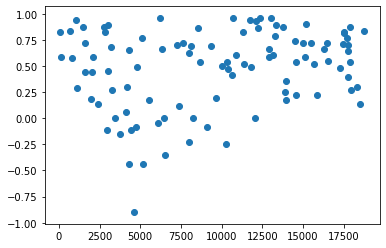

In [33]:
# Since we have a lot of users in our database, let's restrict our view to the first 100.
x = pearsonDF.userId[:101]
y = pearsonDF.similarityIndex[:101]
plt.scatter(x, y)
plt.show()  
# or plt.savefig("PearsonScatter.png")

In [34]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,userId
12193,1.0,86867
16805,1.0,170013
9309,1.0,36011
13681,1.0,114683
9650,1.0,42025


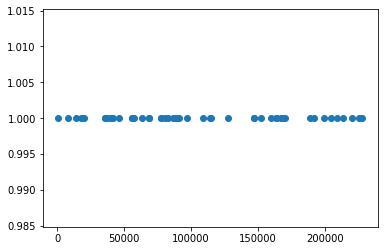

In [36]:
# Let's replot the top 50 from our sorted list
x = topUsers.userId
y = topUsers.similarityIndex
plt.scatter(x, y)
plt.show()

##### Looks like all of them have a similarity index of 1! Which means we are likely to have a good list of movies to recommend our test user.

If our dataset included better parameters that define the user's choices, then we can redefine our similarity index and refine our predictions.

In [39]:
# Let's look at the top 10 users with high similarity of our test user.

top1000Users = pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:1000]

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

top10Users.iplot(x = 'userId', y = 'similarityIndex')


In [46]:
# If you prefer to use Bokeh instead, try this

# If you don't have bokeh install, use the following command

#!pip install bokeh

import bokeh as bk
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.palettes import Plasma
output_notebook()


%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.style.use('seaborn-bright')


x = top1000Users.userId.astype(int)
y = top1000Users.similarityIndex.astype(int)


p = figure(plot_width=800, plot_height=400, title='Similarity of users with test user',
           tools="hover", tooltips="@userId : @similarityIndex")

p.scatter(x=x, y=y, size = 8, color = 'blue', alpha =0.5)
show(p)


p.xaxis.axis_label = "User ID"
p.yaxis.axis_label = 'Similarity of users with test user'
# p.xaxis.major_label_orientation = 1.2
# p.y_range.start = 0
# p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
# p.legend.location = "top_center"
# p.legend.orientation = "horizontal"


Loading BokehJS ...

In [48]:
# Interesting, looks like all of our 1000 users have an exact 1 similarity index!

# We can also look at the entire user list just for the sake of it, although, while making a prediction for our test user, the entire data is not very useful since we will only look at the first few users anyway.

x = pearsonDF.userId.astype(int)
y = pearsonDF.similarityIndex.astype(int)


p = figure(plot_width=800, plot_height=400, title='Similarity of users with test user',
           tools="hover", tooltips="@userId : @similarityIndex")

p.scatter(x=x, y=y, size = 8, color = 'blue', alpha =0.5)
show(p)


p.xaxis.axis_label = "User ID"
p.yaxis.axis_label = 'Similarity of users with test user'
# p.xaxis.major_label_orientation = 1.2
# p.y_range.start = 0
# p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
# p.legend.location = "top_center"
# p.legend.orientation = "horizontal"


topUsersRating=topUsers.merge(ratings_df, left_on='userId', right_on='userId', how='inner')
topUsersRating.head()

,similarityIndex,userId,movieId,rating
0,1.0,86867,1,3.0
1,1.0,86867,6,3.0
2,1.0,86867,16,3.5
3,1.0,86867,19,2.0
4,1.0,86867,21,3.0


In [49]:
# Let's then multiplies the similarity by the user's rating to get the weighted ratings!
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,movieId,rating,weightedRating
0,1.0,86867,1,3.0,3.0
1,1.0,86867,6,3.0,3.0
2,1.0,86867,16,3.5,3.5
3,1.0,86867,19,2.0,2.0
4,1.0,86867,21,3.0,3.0


In [50]:
# Now let us apply a sum to the topUsers after grouping it up by the movieId
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,47.0,173.5
2,3.0,10.0
3,1.0,4.0
4,1.0,2.0
5,5.0,10.0


##### The similarity index and the weighted ratings are related to each other, so, let's see if that is the case. Later, we will be using a weighted average to generate the similarity index.

In [51]:
x = tempTopUsersRating.sum_similarityIndex.astype(int)
y = tempTopUsersRating.sum_weightedRating.astype(int)


p = figure(plot_width=800, plot_height=400, title='Similarity Index vs Weighted Ratings of top users')

p.scatter(x=x, y=y, size = 8, color = 'orange', alpha =0.5)
show(p)


p.xaxis.axis_label = "Similarity Index"
p.yaxis.axis_label = 'Weighted Rating'
# p.xaxis.major_label_orientation = 1.2
# p.y_range.start = 0
# p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
# p.legend.location = "top_center"
# p.legend.orientation = "horizontal"

In [54]:
# Let's now create an empty dataframe and store our final recommendations
recommendation_df = pd.DataFrame()

# We can created a __weighted average of recommendation scores (WARS)__ using the two variables we generated earlier
recommendation_df['WARS'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']

# Let's also include the Movie ID from our index for the sake of completion
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()

,WARS,movieId
movieId,,
1,3.691489,1
2,3.333333,2
3,4.000000,3
4,2.000000,4
5,2.000000,5


In [58]:
x = recommendation_df.movieId.astype(str)
y = recommendation_df.WARS.astype(int)


p = figure(plot_width=800, plot_height=400, title='Weighted Average Recommendation Scores of each Movie')

p.scatter(x=x, y=y, size = 8, color = 'magenta', alpha =0.9)
show(p)


p.xaxis.axis_label = "Movie ID"
p.yaxis.axis_label = 'Weighted Average Recommendation Scores(WARS)'
# p.xaxis.major_label_orientation = 1.2
# p.y_range.start = 0
# p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
# p.legend.location = "top_center"
# p.legend.orientation = "horizontal"

##### Now, from our list of movies, we need to identify the movies we want to recommend.

Here we have to make an important decision. Given that there are a lot movies that have the highest WARS rating of 5.0, we need to decide how many of those movies to recommend. Again, if we had access to better markers for user preferences, we could include that information to improve our predictions. Since, we do not have that information, we can use other data driven means to make recommendations. 

For instance, we can randomly pull a set number of movies out of all the movies with top WARS rating. Another way is to simply sort our table and recommend the top x movies from our sorted list.

In [59]:
# Let's look at the top 10 movies with our weighted average
recommendation_df = recommendation_df.sort_values(by='WARS', ascending=False)
recommendation_df.head(10)

,WARS,movieId
movieId,,
89090,5.0,89090
48744,5.0,48744
44587,5.0,44587
74573,5.0,74573
188,5.0,188
7560,5.0,7560
45642,5.0,45642
4705,5.0,4705
108778,5.0,108778


##### Unfortunately, we are not sure what movies these are! So, let's match the movieId to the name of the movie so we can identify the movies that we are recommending by name!

In [60]:
movies_df.loc[movies_df['movieId'].isin(recommendation_df.head(10)['movieId'].tolist())]

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
186,188,"Prophecy, The","[Fantasy, Horror, Mystery]",1995,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4548,4642,Hedwig and the Angry Inch,"[Comedy, Drama, Musical]",2000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4611,4705,"Cage aux Folles, La",[Comedy],1978,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7364,7560,Fail-Safe,"[Drama, Thriller, War]",1964,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10925,44587,Nanook of the North,"[Documentary, Drama]",1922,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11050,45642,Parting Glances,"[Comedy, Drama, Romance]",1986,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11408,48744,Shortbus,"[Comedy, Drama, Romance]",2006,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14918,74573,"Vicious Kind, The","[Comedy, Drama]",2009,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17768,89090,Bill Cunningham New York,[Documentary],2011,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22837,108778,Stranger by the Lake (L'inconnu du lac),"[Drama, Romance]",2013,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### It appears we have a lot of information here that is unwanted! We can simplify the recommendation table by only showing the name of the movie and the year it was released (or whatever columns/information you are interested in).

In [70]:
full_recommendation_df = pd.DataFrame()
full_recommendation_df = movies_df.loc[movies_df['movieId'].isin(recommendation_df.head(10)['movieId'].tolist())]
full_recommendation_df_truncated = full_recommendation_df[['title', 'year']]
full_recommendation_df_truncated

,title,year
186,"Prophecy, The",1995
4548,Hedwig and the Angry Inch,2000
4611,"Cage aux Folles, La",1978
7364,Fail-Safe,1964
10925,Nanook of the North,1922
11050,Parting Glances,1986
11408,Shortbus,2006
14918,"Vicious Kind, The",2009
17768,Bill Cunningham New York,2011
22837,Stranger by the Lake (L'inconnu du lac),2013


### That ends this portfolio project on recommending movies based on user preferences.

In this project, I showed two methods to recommend movies - Content based and Collaborative filtering based.
Please email me at shafeem@uci.edu if you have question.
